In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Save datetime for submission
test_datetime = test_df['datetime'].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (10886, 12)
Test shape: (6493, 9)


In [8]:
# ==================== PREPROCESSING FUNCTION ====================
def preprocess_data(df, scaler=None, is_train=True):
    """Preprocess train or test data with same transformations"""
    df = df.copy()
    
    # Convert datetime
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Extract time features
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['dayofyear'] = df['datetime'].dt.dayofyear
    
    # Cyclical encoding for time features
    df['day_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    df['hr_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hr_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['mnth_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['mnth_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Drop unnecessary columns
    cols_to_drop = ['datetime', 'dayofyear', 'hour', 'month', 'day', 'year']
    if 'casual' in df.columns:
        cols_to_drop.extend(['casual', 'registered'])
    
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    # One-hot encoding for categorical variables
    cat_cols = ['season', 'weather']
    if 'holiday' not in df.columns and 'workingday' in df.columns:
        cat_cols.append('workingday')
    
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)
    
    # Handle target variable and outliers (only for training)
    if is_train and 'count' in df.columns:
        # Remove outliers
        Q1 = df['count'].quantile(0.25)
        Q3 = df['count'].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df['count'] > Q1 - IQR * 1.5) & (df['count'] < Q3 + IQR * 1.5)]
        
        # Scale target
        if scaler is None:
            scaler = MinMaxScaler()
            df['count'] = scaler.fit_transform(df[['count']])
        else:
            df['count'] = scaler.transform(df[['count']])
        
        return df, scaler
    
    return df


In [10]:
print("\nPreprocessing training data...")
train_processed, count_scaler = preprocess_data(train_df, is_train=True)

print("Preprocessing test data...")
test_processed = preprocess_data(test_df, is_train=False)

# Separate target variable
y = train_processed['count']
X = train_processed.drop('count', axis=1)

# Align test data columns with train data
for col in X.columns:
    if col not in test_processed.columns:
        test_processed[col] = 0

test_processed = test_processed[X.columns]

print("\nTrain features shape:", X.shape)
print("Test features shape:", test_processed.shape)


Preprocessing training data...
Preprocessing test data...

Train features shape: (10583, 19)
Test features shape: (6493, 19)


In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=100
)

print("\nTrain set:", X_train.shape)
print("Validation set:", X_val.shape)



Train set: (8466, 19)
Validation set: (2117, 19)


In [16]:
print("\n" + "="*50)
print("BUILDING NEURAL NETWORK MODEL")
print("="*50)

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True
)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nModel Summary:")
model.summary()



BUILDING NEURAL NETWORK MODEL

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,441 (52.50 KB)

 Trainable params: 13,441 (52.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
print("\n" + "="*50)
print("TRAINING MODEL")
print("="*50)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


TRAINING MODEL
Epoch 1/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - loss: 0.9007 - mae: 0.5995 - val_loss: 0.0505 - val_mae: 0.1817
Epoch 2/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.0788 - mae: 0.2169 - val_loss: 0.0521 - val_mae: 0.1730
Epoch 3/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 0.0593 - mae: 0.1903 - val_loss: 0.0477 - val_mae: 0.1689
Epoch 4/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.0535 - mae: 0.1793 - val_loss: 0.0435 - val_mae: 0.1638
Epoch 5/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 0.0490 - mae: 0.1714 - val_loss: 0.0416 - val_mae: 0.1620
Epoch 6/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 0.0458 - mae: 0.1654 - val_loss: 0.0410 - val_mae: 0.1523
Epoch 7/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0433 - mae: 0.1609 - val_loss: 0.0379 - val_mae: 0.1495
Epoch 8/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 0.0410 - mae: 0.1564 - val_loss: 0.0373 - val_mae: 0.1417
Epoch 9/150
265/

In [20]:
print("\n" + "="*50)
print("EVALUATION")
print("="*50)

y_val_pred = model.predict(X_val)
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"Validation R²: {r2_score(y_val, y_val_pred):.4f}")



EVALUATION
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
Validation MAE: 0.0711
Validation R²: 0.8314


In [24]:
print("\n" + "="*50)
print("RETRAINING ON FULL DATA FOR SUBMISSION")
print("="*50)

final_model = models.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

final_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
final_model.fit(X, y, epochs=100, batch_size=32, verbose=0)



RETRAINING ON FULL DATA FOR SUBMISSION



GENERATING SUBMISSION FILE
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step

✓ Submission file 'submission.csv' created successfully!
✓ Shape: (6493, 2)

First few predictions:
              datetime  count
0  2011-01-20 00:00:00     12
1  2011-01-20 01:00:00     12
2  2011-01-20 02:00:00     12
3  2011-01-20 03:00:00     12
4  2011-01-20 04:00:00     12
5  2011-01-20 05:00:00     39
6  2011-01-20 06:00:00     98
7  2011-01-20 07:00:00    210
8  2011-01-20 08:00:00    361
9  2011-01-20 09:00:00    181

Prediction Statistics:
Mean: 186.72
Median: 174.00
Min: 12
Max: 531

✓ Training history plot saved as 'training_history.png'


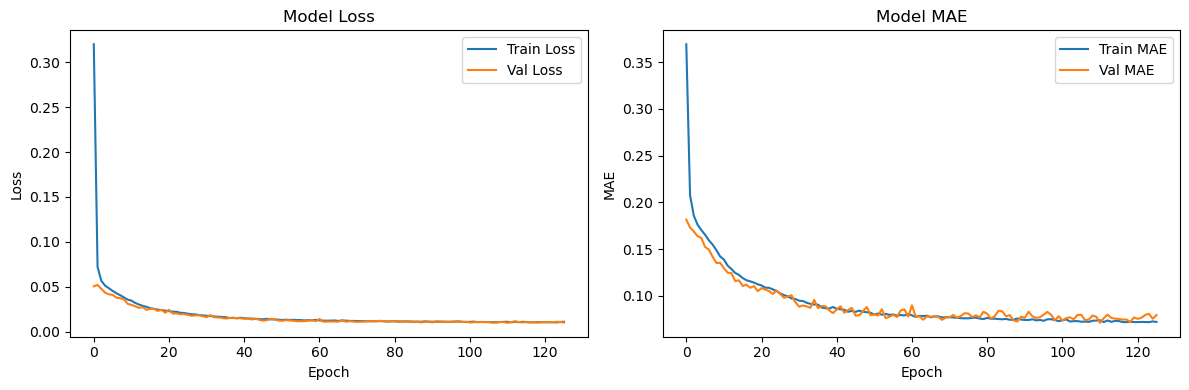

In [28]:

# ==================== GENERATE SUBMISSION ====================
print("\n" + "="*50)
print("GENERATING SUBMISSION FILE")
print("="*50)

# Make predictions on test data
test_predictions_scaled = final_model.predict(test_processed)

# Inverse transform to original scale
test_predictions = count_scaler.inverse_transform(test_predictions_scaled)

# Ensure non-negative predictions
test_predictions = np.maximum(0, test_predictions.flatten())

# Create submission dataframe
submission = pd.DataFrame({
    'datetime': test_datetime,
    'count': test_predictions.astype(int)
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

print("\n✓ Submission file 'submission.csv' created successfully!")
print(f"✓ Shape: {submission.shape}")
print("\nFirst few predictions:")
print(submission.head(10))

# Display prediction statistics
print(f"\nPrediction Statistics:")
print(f"Mean: {submission['count'].mean():.2f}")
print(f"Median: {submission['count'].median():.2f}")
print(f"Min: {submission['count'].min()}")
print(f"Max: {submission['count'].max()}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png', dpi=100, bbox_inches='tight')
print("\n✓ Training history plot saved as 'training_history.png'")